# Generating a training set of typical geological structures

(Based on 4-Create-model)

In [1]:
from matplotlib import rc_params

In [2]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [3]:
import sys, os
import matplotlib.pyplot as plt
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy.history
import numpy as np

In [4]:
%matplotlib inline

In [5]:
rcParams.update({'font.size': 20})

Single normal fault
--------------

We first start with a very simple 3-layer model of a fault 

In [6]:
reload(pynoddy.history)
reload(pynoddy.events)
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 3,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3'],
                  'layer_thickness' : [1500, 500, 1500]}
nm.add_event('stratigraphy', strati_options )




# The following options define the fault geometry:
fault_options = {'name' : 'Fault_E',
                 'pos' : (4000, 0, 5000),
                 'dip_dir' : 90.,
                 'dip' : 60,
                 'slip' : 1000}

nm.add_event('fault', fault_options)
history = 'normal_fault.his'
output_name = 'normal_fault_out'
nm.write_history(history)

In [7]:
# Compute the model
pynoddy.compute_model(history, output_name) 

''

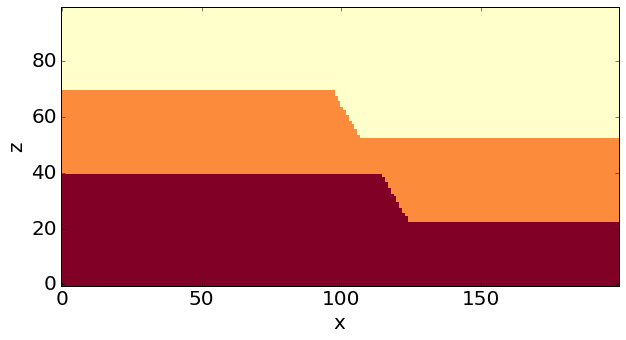

In [8]:
# Plot output
import pynoddy.output
reload(pynoddy.output)
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('y', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title = "",
                  savefig = False, fig_filename = "normal_fault.eps")

**Idea**: add tilting event?!

Let's make it a bit simpler (for our ML algorithm): we simply set block id's to either 1's or 0's (be careful about this choice... is it a good idea?)

In [9]:
nout.block[np.where(nout.block == 3)] = 1

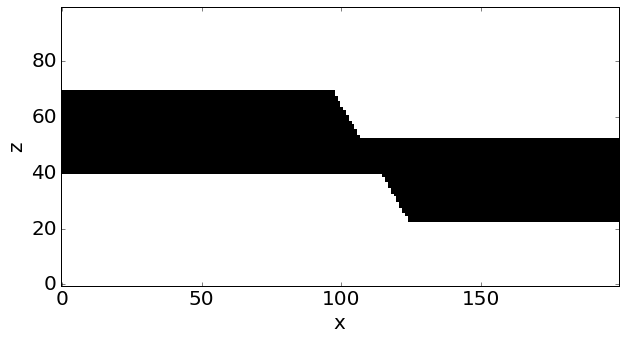

In [10]:
nout.plot_section('y', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title = "", cmap = 'gray_r',
                  savefig = False, fig_filename = "normal_fault.eps")

## Implementation in an experiment object

In [11]:
import pynoddy.experiment
reload(pynoddy.experiment)
reload(pynoddy.history)
reload(pynoddy.events)

<module 'pynoddy.events' from '/Users/flow/git/pynoddy/pynoddy/events.pyc'>

Create experiment object for training set: (idea: a test set should easily be produced with new draws from the simulation!)

In [12]:
ts =  pynoddy.experiment.Experiment(history = 'normal_fault.his')

In [13]:
sec = ts.get_section()

In [14]:
sec.block[np.where(sec.block == 3)] = 1
# ts.plot_section(data = sec.block)

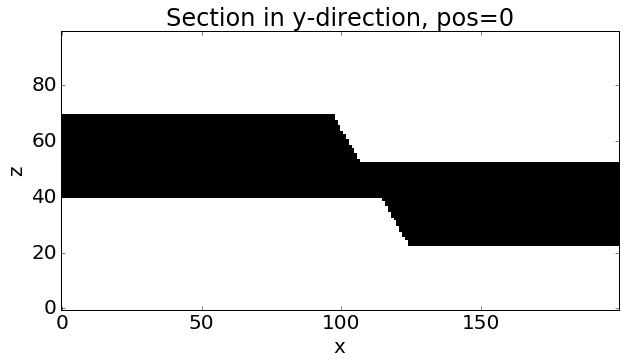

In [15]:
sec.plot_section(cmap = 'gray_r')

Set values for random variables

In [16]:
ts.events[1].properties

{'Angle with the Magn. North': 30.0,
 'Anisotropic Field': 0.0,
 'Apply Alterations': 'ON',
 'Blue': 48.0,
 'Color Name': 'Color 92',
 'Density': 4.0,
 'Green': 153.0,
 'Height': 3500.0,
 'Inclination': 30.0,
 'MagSus Dip': 90.0,
 'MagSus DipDir': 90.0,
 'MagSus Pitch': 0.0,
 'MagSusX': 0.0016,
 'MagSusY': 0.0016,
 'MagSusZ': 0.0016,
 'Name': 'Strat',
 'Num Layers': 3.0,
 'Red': 0.0,
 'Remanent Magnetization': 0.0,
 'Strength': 0.0016,
 'Unit Name': 'layer 3'}

In [17]:
param_stats = [{'event' : 2, 
              'parameter': 'Slip',
              'stdev': 500.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'Dip',
              'stdev': 10.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'X',
              'stdev': 500.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'Z',
              'stdev': 1500.0,
              'type': 'normal'}]

ts.set_parameter_statistics(param_stats)

In [18]:
ts.random_draw()

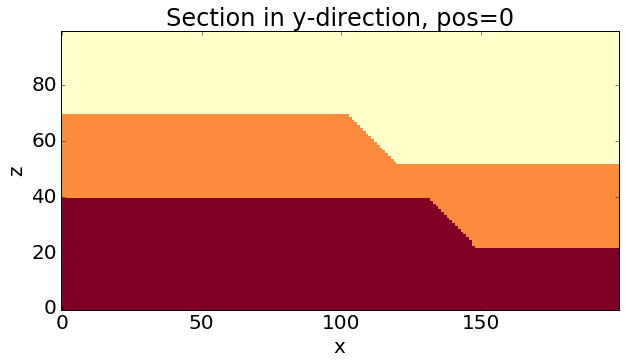

In [19]:
ts.plot_section()

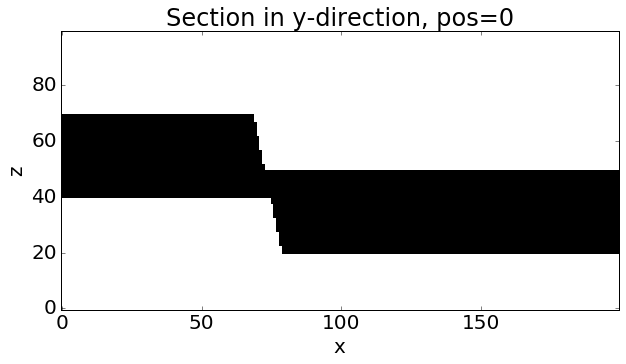

In [20]:
ts.random_draw()
sec = ts.get_section()
sec.block[np.where(sec.block == 3)] = 1
# ts.plot_section(data = sec.block)
sec.plot_section(cmap = 'gray_r')

### And now: changing to reverse fault

Use same base object, but change slip to negative to invoke reverse fault

In [21]:
import copy
ts_rev = copy.deepcopy(ts)
ts_rev.events[2].properties['Slip'] = -1000
ts_rev.events[2].properties['X'] += -1000
# "freeze" to update model base parameters
ts_rev.freeze()

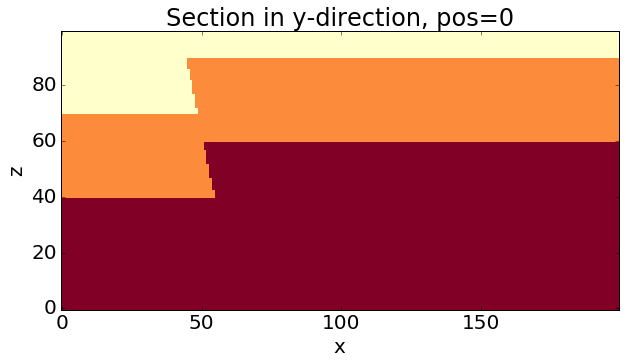

In [22]:
ts_rev.plot_section()

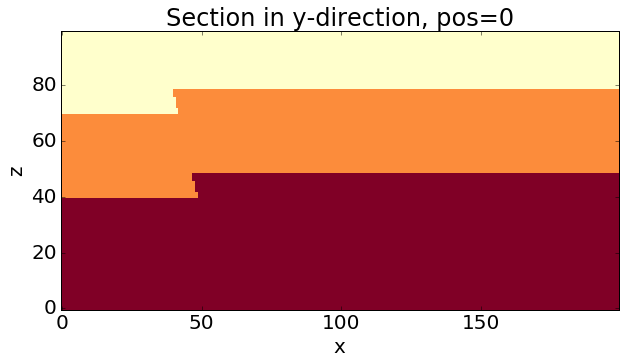

In [23]:
ts_rev.random_draw()
ts_rev.plot_section()

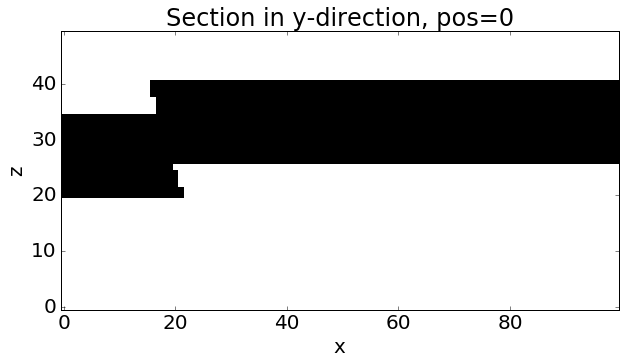

In [24]:
ts_rev.change_cube_size(100)
ts_rev.random_draw()
sec = ts_rev.get_section()
sec.block[np.where(sec.block == 3)] = 1
# ts.plot_section(data = sec.block)
sec.plot_section(cmap = 'gray_r')

In [25]:
sec.block.shape

(100, 1, 50)

## Generate training and test sets

Use same concept as for training sets from ML examples.

## Change layer thickness

Next step: change additionally the thickness of the sedimentary sequences. Note: requires some adjustments (which are anyway overdue...) in pynoddy.history to correctly read and change sedimentary sequences.